# Прогнозирование оттока клиентов

## Описание задачи

Чтобы привлечь клиентов, сеть отелей «Как в гостях» добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400
- категория B: за ночь — 800, разовое обслуживание — 350
- категория C: за ночь — 600, разовое обслуживание — 350
- категория D: за ночь — 550, разовое обслуживание — 150
- категория E: за ночь — 500, разовое обслуживание — 150
- категория F: за ночь — 450, разовое обслуживание — 150
- категория G: за ночь — 350, разовое обслуживание — 150

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Описание данных

Всего 25 колонок

- **Обучающие признаки**
  - **Численные признаки**
    - `id` — номер записи
    - `adults` — количество взрослых постояльцев
    - `arrival_date_year` — год заезда
    - `arrival_date_week_number` — неделя заезда
    - `arrival_date_day_of_month` — день заезда
    - `babies` — количество младенцев
    - `booking_changes` — количество изменений параметров заказа
    - `children` — количество детей от 3 до 14 лет
    - `days_in_waiting_list` — сколько дней заказ ожидал подтверждения
    - `lead_time` — количество дней между датой бронирования и датой прибытия
    - `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента
    - `previous_cancellations` — количество отменённых заказов у клиента
    - `required_car_parking_spaces` — необходимость места для автомобиля
    - `stays_in_weekend_nights` — количество ночей в выходные дни
    - `stays_in_week_nights` — количество ночей в будние дни
    - `total_nights` — общее количество ночей
    - `total_of_special_requests` — количество специальных отметок
  - **Категориальные признаки**
    - `arrival_date_month` — месяц заезда
    - `country` — гражданство постояльца
    - `customer_type` — тип заказчика
      - `Contract` — договор с юридическим лицом
      - `Group` — групповой заезд
      - `Transient` — не связано с договором или групповым заездом
      - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`
    - `distribution_channel` — канал дистрибуции заказа
    - `is_repeated_guest` — признак того, что гость бронирует номер второй раз
    - `meal` — опции заказа
      - `SC` — нет дополнительных опций
      - `BB` — включён завтрак
      - `HB` — включён завтрак и обед
      - `FB` — включён завтрак, обед и ужин
    - `reserved_room_type` — тип забронированной комнаты
- **Целевой признак**
  - `is_canceled` — отмена заказа

## Задача в терминах бизнеса

- Главная метрика бизнеса для отеля — прибыль
- Нужно максимизировать прибыль

## Гипотеза

- Нулевая гипотеза, $H_0$ — внедрение депозитов, с использованием модели не изменит прибыль

## Задача в терминах машинного обучения

- Классификация — Предсказание отмены брони клиентом (да/нет)
- Метрика — Собственная или максимизация Recall

## Подключение библиотек

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, make_scorer, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

Объявление констант

In [3]:
RANDOM_STATE = 12345

## Получение данных

In [4]:
train = pd.read_csv('./data/hotel_train.csv')
test = pd.read_csv('./data/hotel_test.csv')

## Изучение и предобработка данных

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

Явных пропусков в данных нет

In [6]:
train.sample(5, random_state=RANDOM_STATE).T

,39312,28558,17935,17697,24642
id,57667,36498,25875,25637,32582
is_canceled,1,1,0,0,1
lead_time,233.0,0.0,131.0,16.0,251.0
arrival_date_year,2015,2016,2015,2015,2016
arrival_date_month,September,June,August,August,March
arrival_date_week_number,38,24,33,33,13
arrival_date_day_of_month,18,7,15,13,22
stays_in_weekend_nights,0,0,2,2,0
stays_in_week_nights,1,1,1,3,3
adults,2.0,2.0,2.0,2.0,2.0


`is_canceled` бинарный признак, изменим тип данный на булев.

In [ ]:
train['is_canceled'] = train['is_canceled'].astype('bool')

`lead_time` содержит только целочислительные значения. Изменим тип данных на `int`.

In [40]:
((train['lead_time'] - train['lead_time'].astype('int')) != 0).unique()

array([False])

In [41]:
train['lead_time'] = train['lead_time'].astype('int')

Аномалий у `lead_time` нет

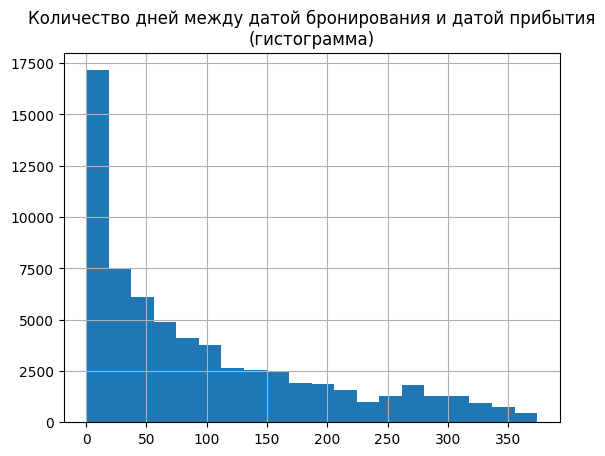

In [42]:
train['lead_time'].hist(bins=20).set_title('Количество дней между датой бронирования и датой прибытия\n(гистограмма)');

Аномалий у `arrival_date_year` нет

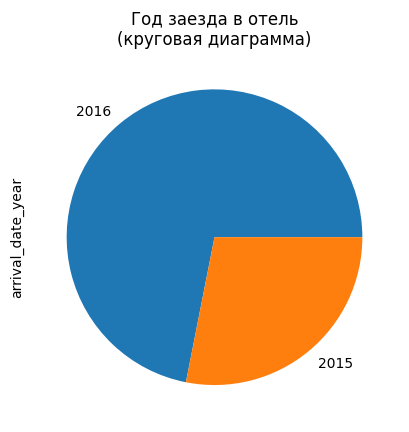

In [16]:
train['arrival_date_year'].value_counts().plot.pie().set_title('Год заезда в отель\n(круговая диаграмма)');

Аномалий у `arrival_date_month` нет

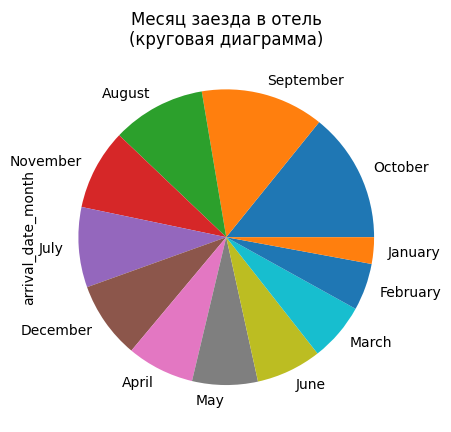

In [24]:
train['arrival_date_month'].value_counts().plot.pie().set_title('Месяц заезда в отель\n(круговая диаграмма)');

Аномалий у `arrival_date_week_number` нет

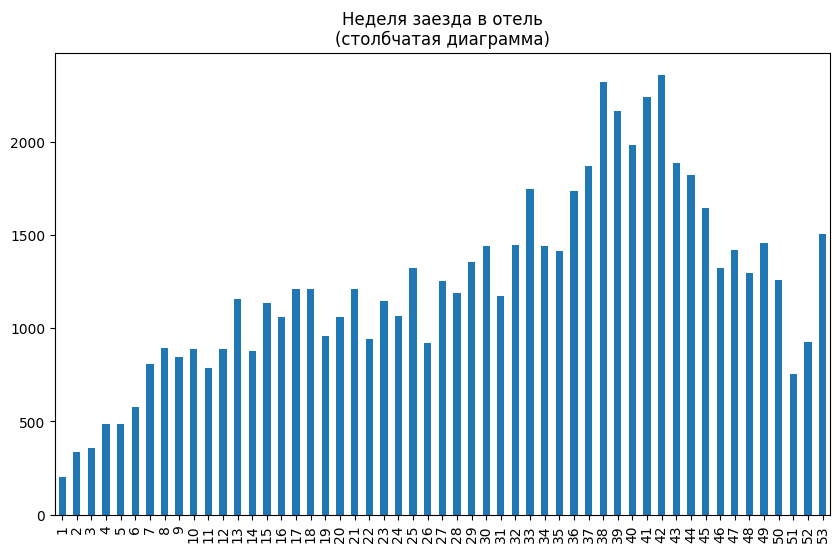

In [35]:
train['arrival_date_week_number'].value_counts().sort_index().plot.bar(figsize=(10, 6)) \
    .set_title('Неделя заезда в отель\n(столбчатая диаграмма)');

Аномалий у `arrival_date_day_of_month` нет

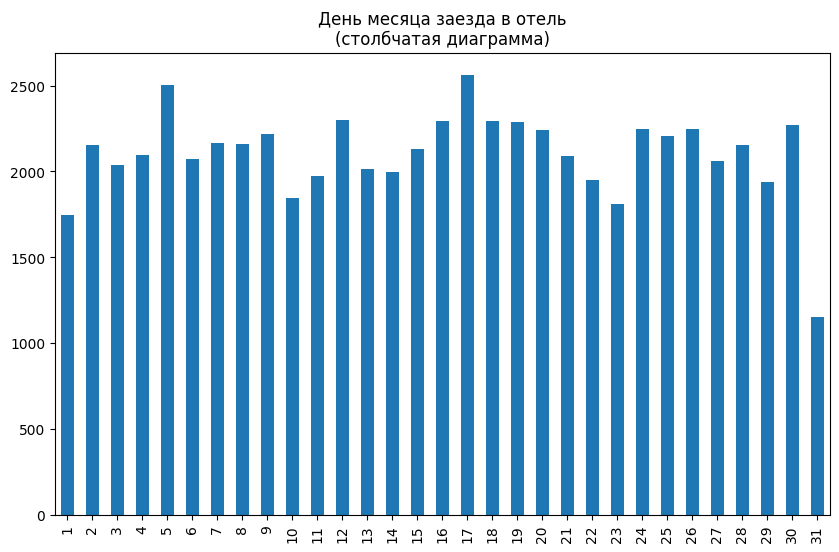

In [34]:
train['arrival_date_day_of_month'].value_counts().sort_index().plot.bar(figsize=(10, 6)) \
    .set_title('День месяца заезда в отель\n(столбчатая диаграмма)');

`adults` изменим на целочислительный тип

In [49]:
train['adults'] = train['adults'].astype('int')

Аномалий у `adults` нет

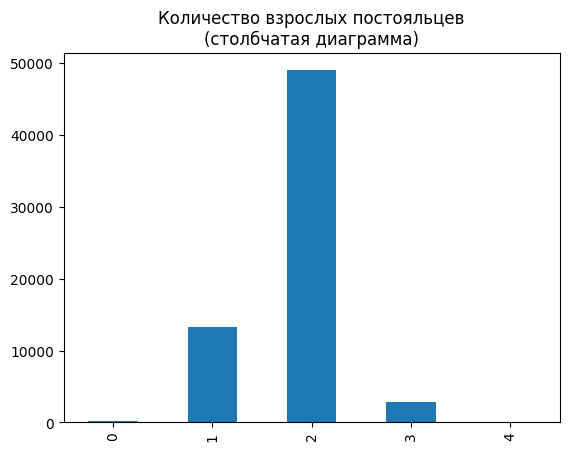

In [50]:
train['adults'].value_counts().sort_index().plot.bar() \
    .set_title('Количество взрослых постояльцев\n(столбчатая диаграмма)');

`children` изменим на целочислительный тип

In [53]:
train['children'] = train['children'].astype('int')

Аномалий у `children` нет. Но количество детей от 3 до 14 лет маленькое.

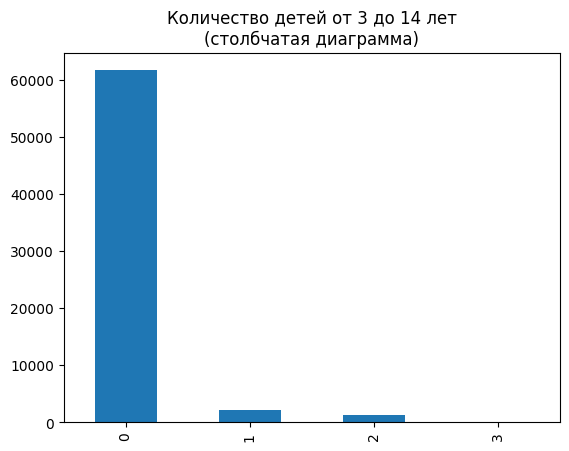

In [54]:
train['children'].value_counts().sort_index().plot.bar() \
    .set_title('Количество детей от 3 до 14 лет\n(столбчатая диаграмма)');

Преобразуем признак в бинарный и назовём `has_children`, что бы было удобнее

In [60]:
train['children'] = train['children'].astype('bool')
train.rename(columns={'children': 'has_children'}, inplace=True)

Удаляем наблюдения, с неадекватными данными, где только дети от 3 до 14 лет, без взрослых

In [75]:
train = train.drop(train[train['has_children'] & (train['adults'] == 0)].index)

Аномалий у `has_children` нет

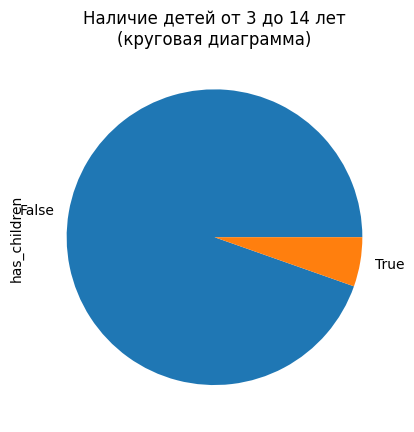

In [72]:
train['has_children'].value_counts().plot.pie().set_title('Наличие детей от 3 до 14 лет\n(круговая диаграмма)');

У `babies` есть аномалии, 9 и 10 младенцев. Кроме того количество младенцев маленькое.

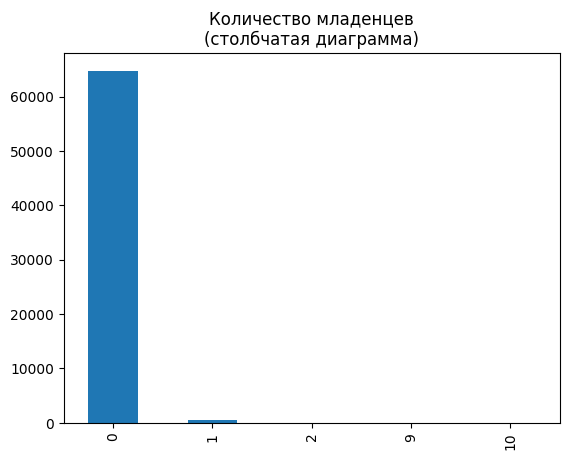

In [57]:
train['babies'].value_counts().sort_index().plot.bar() \
    .set_title('Количество младенцев\n(столбчатая диаграмма)');

Оставляем наблюдения где количество младенцев меньше 9

In [23]:
train['babies'] = train['babies'][train['babies'] < 9]

Преобразуем признак в бинарный и назовём `has_babies`, что бы было удобнее

In [69]:
train['babies'] = train['babies'].astype('bool')
train.rename(columns={'babies': 'has_babies'}, inplace=True)

Удалим наблюдения, с неадекватными данными, где только младенцы, без взрослых

In [77]:
train = train.drop(train[train['has_babies'] & (train['adults'] == 0)].index)

Аномалий у `meal` нет

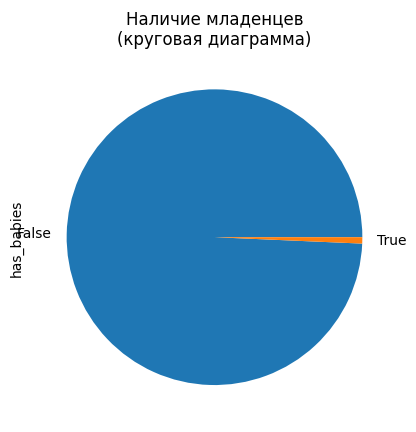

In [78]:
train['has_babies'].value_counts().plot.pie().set_title('Наличие младенцев\n(круговая диаграмма)');

`meal` содержит опции заказа с пробелами, удалим пробелы

In [14]:
train['meal'].unique(), test['meal'].unique()

(array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
       dtype=object),
 array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
       dtype=object))

In [15]:
train['meal'] = train['meal'].str.strip()
test['meal'] = test['meal'].str.strip()

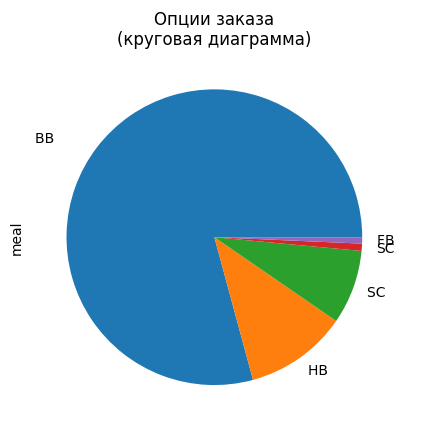

In [80]:
train['meal'].value_counts().plot.pie().set_title('Опции заказа\n(круговая диаграмма)');

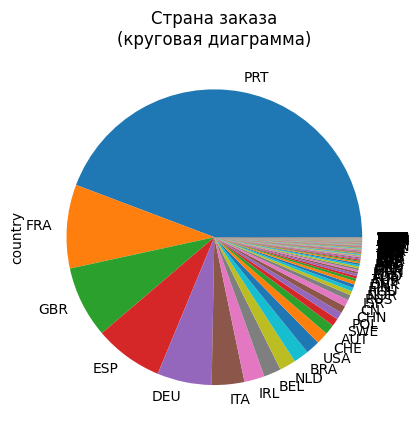

In [85]:
train['country'].value_counts().plot.pie().set_title('Страна заказа\n(круговая диаграмма)');

In [79]:
print(train.columns)
print({k: v for k, v in zip(numerals_column_titles_list, numerals_column_names_list)})
print({k: v for k, v in zip(categorical_column_titles_list, categorical_column_names_list)})


Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'has_children', 'has_babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')
{'количество взрослых постояльцев': 'adults', 'год заезда': 'arrival_date_year', 'неделя заезда': 'arrival_date_week_number', 'день заезда': 'arrival_date_day_of_month', 'количество младенцев': 'babies', 'количество изменений параметров заказа': 'booking_changes', 'количество детей от 3 до 14 лет': 'children', 'сколько дней заказ ожидал подтверждения': 'days_in_waiting_list', 'количество дней между датой

Допустимое кол-во наблюдений для удаления:

In [8]:
deleted = 0 # Для счёта удаляемых данных

can_be_deleted = int(train.shape[0] * 0.10)
can_be_deleted

6522

Удаляем выбросы:

In [10]:
def calculate_emissions(column):
    """Найти индексы признаков с выбросами"""
    
    # ❗ Повторяет расчёты при постройки box графика — ящика с усами
    
    describe = column.describe()
    
    # Межквартильный размах
    iqr = describe['75%'] - describe['25%']
    
    # Максимально возможные значения без ограничений min, max значений распределения
    max_up = describe['75%'] + 1.5 * iqr
    max_down = describe['25%'] - 1.5 * iqr
    
    # Верхний и нижний усы
    up = max_up if max_up <= describe['max'] else describe['max']
    down = max_down if max_down >= describe['min'] else describe['min']
    
    # Выбираем из наблюдений те, что выходят за пределы
    indexes = column.pipe(lambda x: x[down<x]).pipe(lambda x: x[up<x]).index
    
    print('Количество удалённых выбросов:', len(indexes))
    
    return indexes

# удаляем выбросы
train = train.drop(index=calculate_emissions(train['lead_time'])).dropna()

Количество удалённых выбросов: 493


Исправляем пробелы в типе забронированной комнаты и опциях заказа:

In [12]:
train['reserved_room_type'].unique(), test['reserved_room_type'].unique()

(array(['A               ', 'C               ', 'D               ',
        'E               ', 'G               ', 'F               ',
        'B               '], dtype=object),
 array(['A               ', 'E               ', 'G               ',
        'D               ', 'F               ', 'C               ',
        'B               '], dtype=object))

In [13]:
train['reserved_room_type'] = train['reserved_room_type'].str.strip()
test['reserved_room_type'] = test['reserved_room_type'].str.strip()

Признаки `stays_in_weekend_nights` (количество ночей в выходные дни) и `stays_in_week_nights` (количество ночей в будние дни) исключаем из использования, предотвращая избыточность в данных, так как их сумма это тоже самое что `total_nights` (общее количество ночей). Так же убираем `id`

In [1]:
numerals_column_names_list = [
    'adults','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
    'babies','booking_changes','children','days_in_waiting_list','lead_time','previous_bookings_not_canceled',
    'previous_cancellations','required_car_parking_spaces','total_nights','total_of_special_requests'
]

numerals_column_titles_list = [
    'количество взрослых постояльцев','год заезда','неделя заезда','день заезда',
    'количество младенцев','количество изменений параметров заказа','количество детей от 3 до 14 лет',
    'сколько дней заказ ожидал подтверждения','количество дней между датой бронирования и датой прибытия',
    'количество подтверждённых заказов у клиента','количество отменённых заказов у клиента',
    'необходимость места для автомобиля','общее количество ночей','количество специальных отметок'
]

categorical_column_names_list = [
    'arrival_date_month','country','customer_type','distribution_channel',
    'is_repeated_guest','meal', 'reserved_room_type'
]

categorical_column_titles_list = [
    'месяц заезда','гражданство постояльца','тип заказчика','канал дистрибуции заказа',
    'гость бронирует номер второй раз','опции заказа','тип забронированной комнаты'
]

target_column_name = 'is_canceled'

### Вывод

## Анализ данных

In [7]:

train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


In [16]:
# Если строить все пары признаков нужно будет 276 графиков
# Построение матрицы рассеяния для многих признаков затратно по вычислительным ресурсам
for_combinations = list(train.columns)
for_combinations.remove('is_canceled')
len(list(combinations(for_combinations, 2)))

276

In [17]:
# Что бы понять зависимости можно посмотреть корреляцию между признаками и `is_canceled`
train.corr().sort_values(by='is_canceled')['is_canceled']

total_of_special_requests        -0.254168
id                               -0.247168
required_car_parking_spaces      -0.185548
booking_changes                  -0.140284
previous_bookings_not_canceled   -0.045408
is_repeated_guest                -0.040108
babies                           -0.029145
arrival_date_year                -0.022435
children                         -0.016262
stays_in_weekend_nights          -0.009897
arrival_date_day_of_month        -0.000704
total_nights                      0.007498
arrival_date_week_number          0.009370
stays_in_week_nights              0.015850
adults                            0.043528
days_in_waiting_list              0.077592
previous_cancellations            0.148853
lead_time                         0.319882
is_canceled                       1.000000
Name: is_canceled, dtype: float64

Отберём признаки наиболее кореллирующие по модулю с `is_canceled` больше чем на 5% — их будем считать самыми важными для изображения на графике матрицы рассеяния

**Наиболее кореллирующие признаки**

- `lead_time` — количество дней между датой бронирования и датой прибытия
- `total_of_special_requests` — количество специальных отметок
- `required_car_parking_spaces` — необходимость места для автомобиля
- `previous_cancellations` — количество отменённых заказов у клиента
- `booking_changes` — количество изменений параметров заказа
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения

In [32]:
correlation_column_names_list = [
    'lead_time','total_of_special_requests','required_car_parking_spaces',
    'previous_cancellations','booking_changes','days_in_waiting_list'
]

Узнаем немного больше о диапазоне дат

In [18]:
dates = train.apply(
    lambda x: datetime.strptime(f"{x['arrival_date_year']} {x['arrival_date_month']} {x['arrival_date_day_of_month']}", "%Y %B %d"),
    axis=1
)

In [19]:
f = dates.describe()

C:\Users\dimka\AppData\Local\Temp\ipykernel_27748\2129099738.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  f = dates.describe()


In [20]:
f['first'], f['last'], f['first'] - f['last']

(Timestamp('2015-07-01 00:00:00'),
 Timestamp('2016-12-31 00:00:00'),
 Timedelta('-549 days +00:00:00'))

Кол-во дней от брони до прибытия сильно связано с номером записи, скорее всего по тому что они идут по порядку вместе со времением, а данные представлены с 2015-09-21 по 2016-11-14 то есть 420 дней. По этому далее используется только `lead_time`, а `id` не используется.

#### Устранение выбросов и аномалий

In [27]:
train[train.drop('id', axis=1).duplicated()]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
13,13,0,72.0,2015,July,27,1,2.0,0.0,0.0,...,0,0,0,A,1,0,Transient,0,1,6
85,87,1,5.0,2015,July,28,5,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,0,1
115,118,0,0.0,2015,July,28,7,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,3,1
127,130,1,1.0,2015,July,28,8,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,1
219,224,0,40.0,2015,July,29,13,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65188,83965,0,269.0,2016,December,53,29,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65189,83966,0,269.0,2016,December,53,29,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65192,83969,0,269.0,2016,December,53,29,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65193,83970,0,269.0,2016,December,53,29,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,1,5


In [28]:
train = train.dropna()

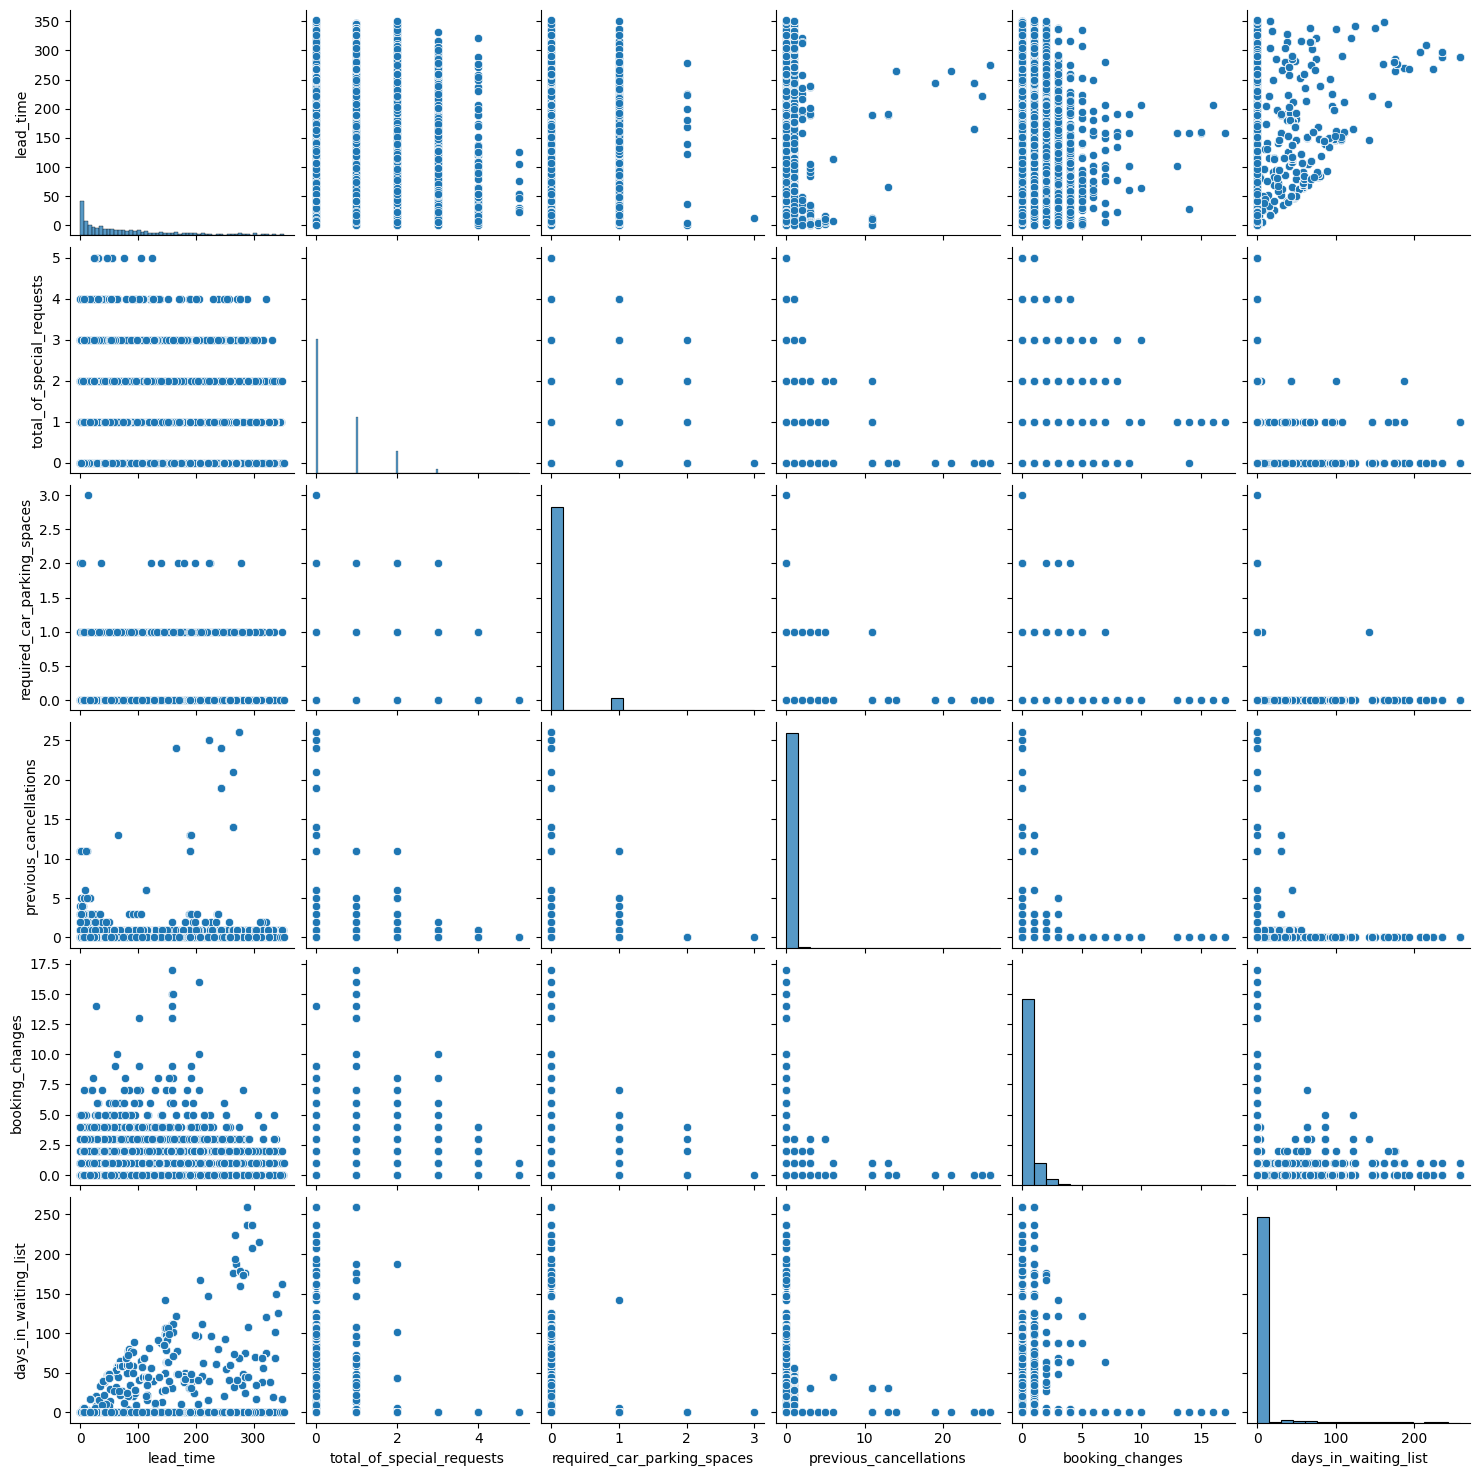

In [31]:
sns.pairplot(train[correlation_column_names_list], title='Наиболее коррелирующие признаки (парная диаграмма)');

#### Доли

Списки численных и категориальных признаков

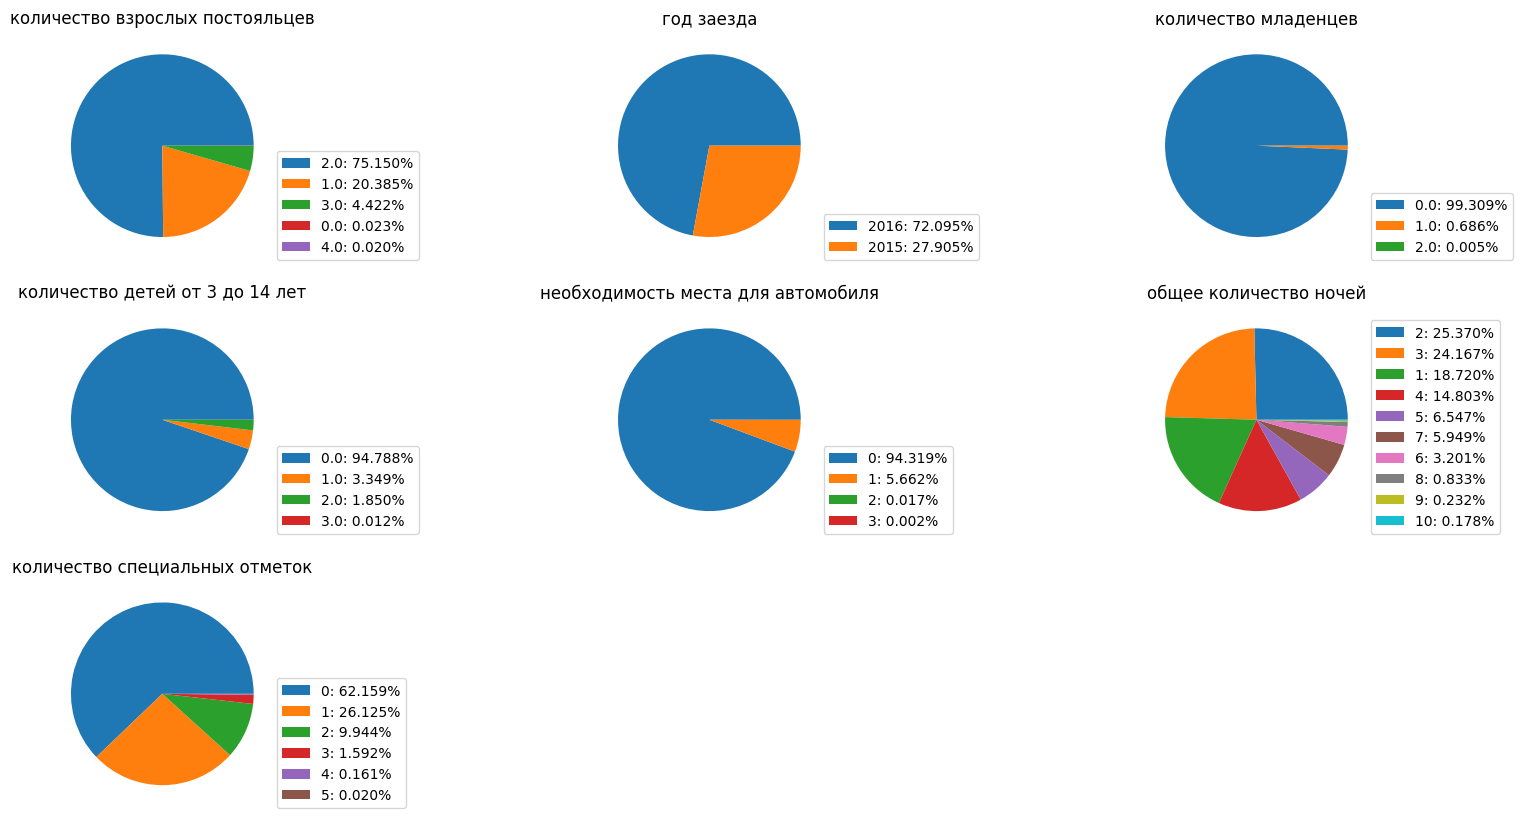

In [33]:
plt.figure(figsize=(20,35))
i = 1
for feature_name, title in zip(numerals_column_names_list, numerals_column_titles_list):
    if not feature_name in ['booking_changes', 'days_in_waiting_list', 'arrival_date_week_number', 'arrival_date_day_of_month', 'lead_time',
                           'previous_bookings_not_canceled', 'previous_cancellations']:
        plt.subplot(10, 3, i)
        counts = train[feature_name].value_counts()
        patches = plt.pie(counts/counts.sum(), normalize=True)
        plt.title(title)
        legend = [f'{y}: {x:.3%}' for x, y in zip(counts/len(train), counts.index)]
        plt.legend(legend, loc=(1, 0))
        i += 1

plt.show()

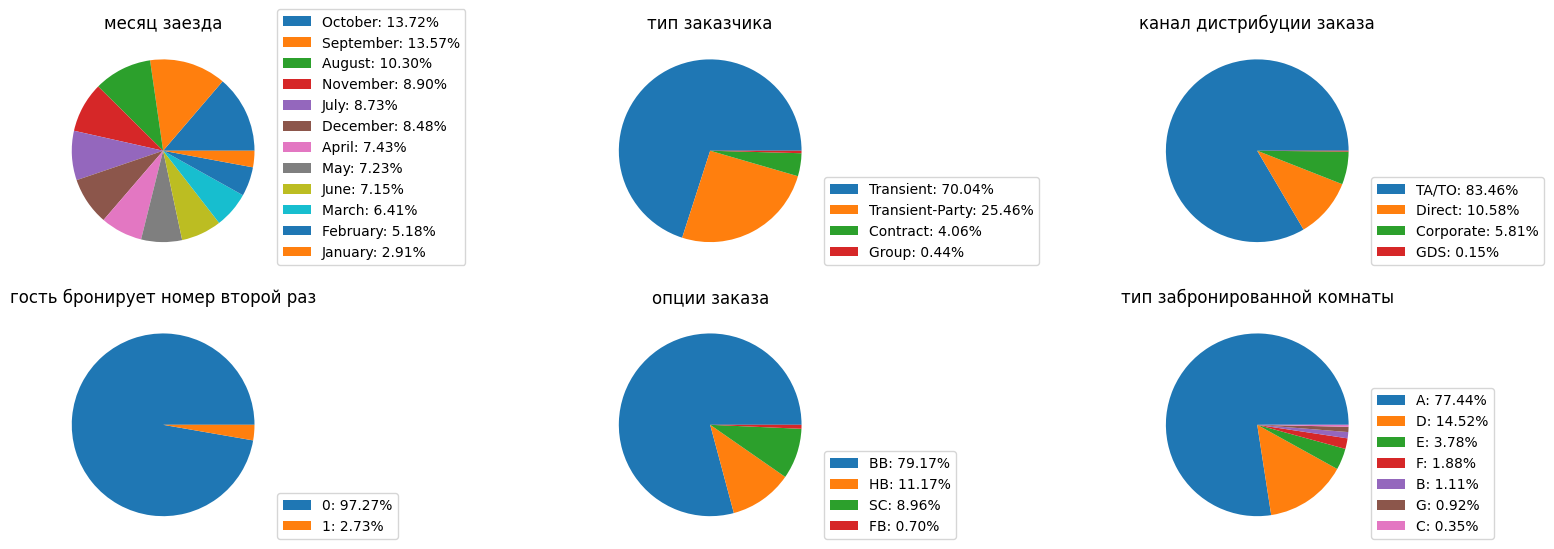

In [34]:
plt.figure(figsize=(20,35))
i = 1
for feature_name, title in zip(categorical_column_names_list, categorical_column_titles_list):
    if not feature_name in ['country']:
        plt.subplot(10, 3, i)
        counts = train[feature_name].value_counts()
        patches = plt.pie(counts/counts.sum(), normalize=True)
        plt.title(title)
        legend = [f'{y}: {x:.2%}' for x, y in zip(counts/len(train), counts.index)]
        plt.legend(legend, loc=(1, 0))
        i += 1

plt.show()

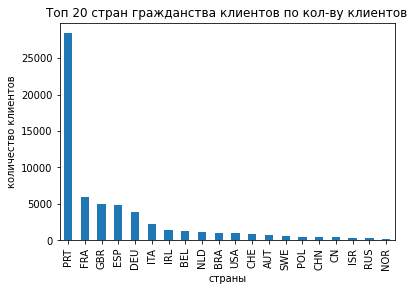

In [28]:
train['country'].value_counts().head(20).plot(kind='bar', xlabel='страны', ylabel='количество клиентов')\
    .set_title('Топ 20 стран гражданства клиентов по кол-ву клиентов');

#### Доля клиентов с визуализацией среди ушедшиx и не ушедших

<Figure size 2000x4000 with 0 Axes>

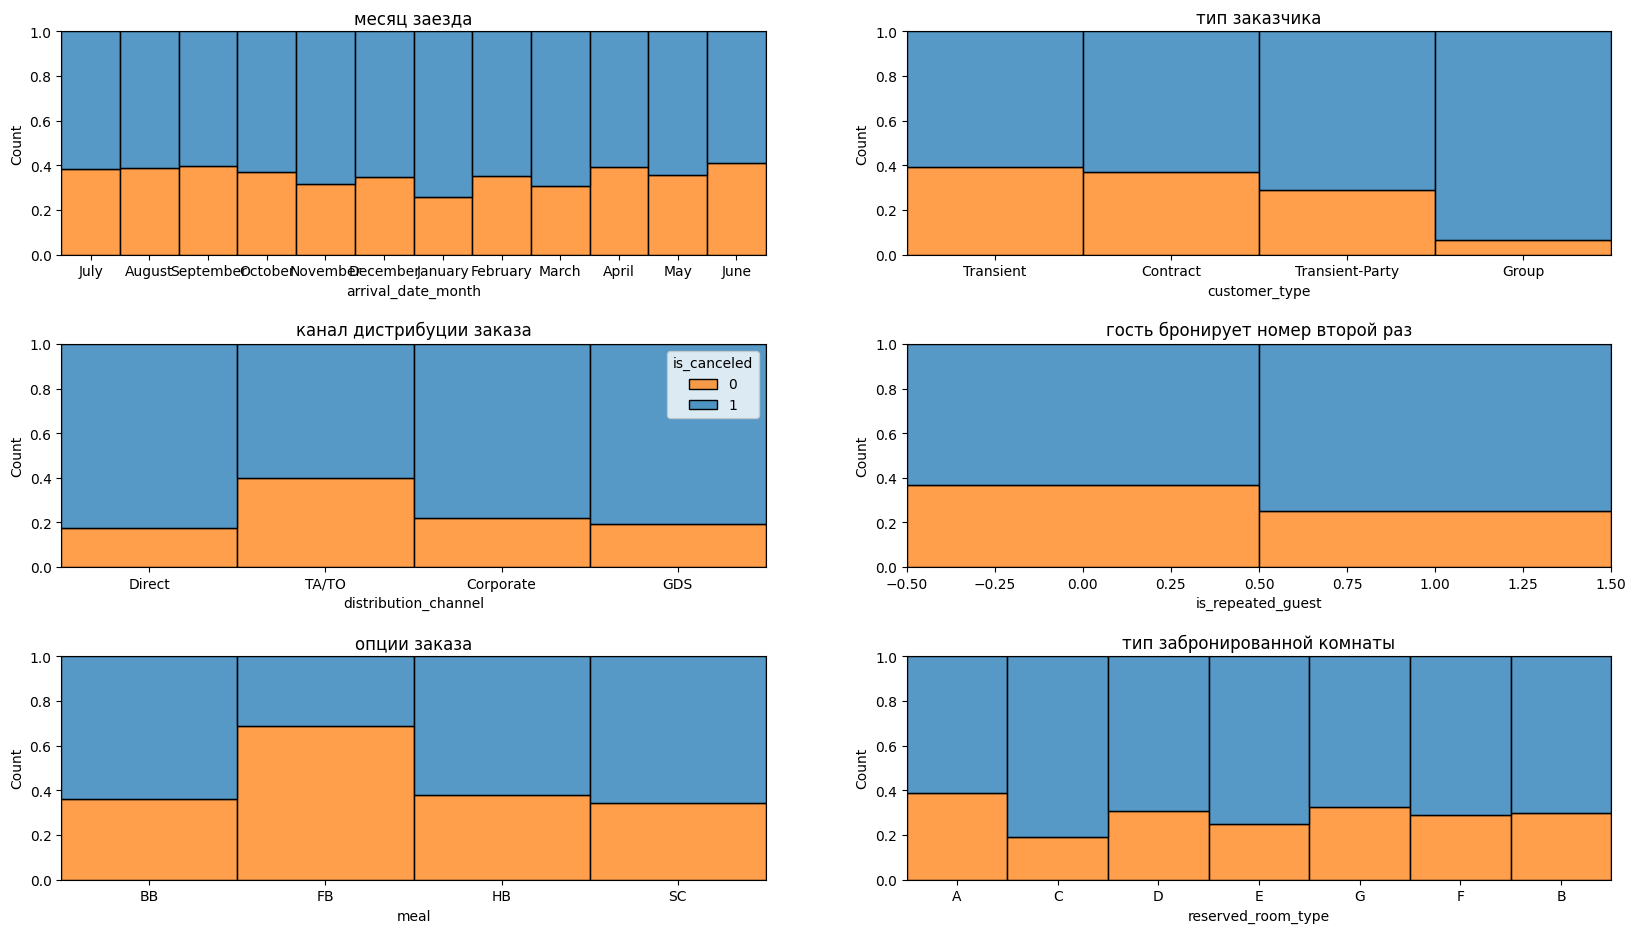

In [38]:
# Размер рисунка
plt.figure(figsize=(20,40));

# Размер каждого графика (относительный), есть разница до или после `plt.subplots_adjust`
plt.subplots(figsize=(20,80));

# Расстояние между графиками, есть разница до или после `plt.subplots`
plt.subplots_adjust(hspace = 0.4);

i = 1
for feature_name, title in zip(categorical_column_names_list, categorical_column_titles_list):
    if feature_name != 'country':
        plt.subplot(20,2,i);
        
        sns.histplot(data=train, x=feature_name, hue='is_canceled', multiple="fill", stat="count", discrete=True, legend=False)\
            .set_title(title);

        if i == 3: plt.legend([0, 1], title='is_canceled');
        i += 1


plt.show();

In [30]:
# Топ 15 стран
re = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'NLD', 'BRA', 'USA', 'CHE', 'AUT', 'SWE', 'POL']

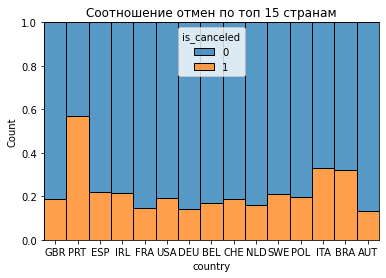

In [31]:
sns.histplot(data=train[train['country'].isin(re)], x='country', hue='is_canceled', multiple="fill", stat="count", discrete=True)\
    .set_title('Соотношение отмен по топ 15 странам');

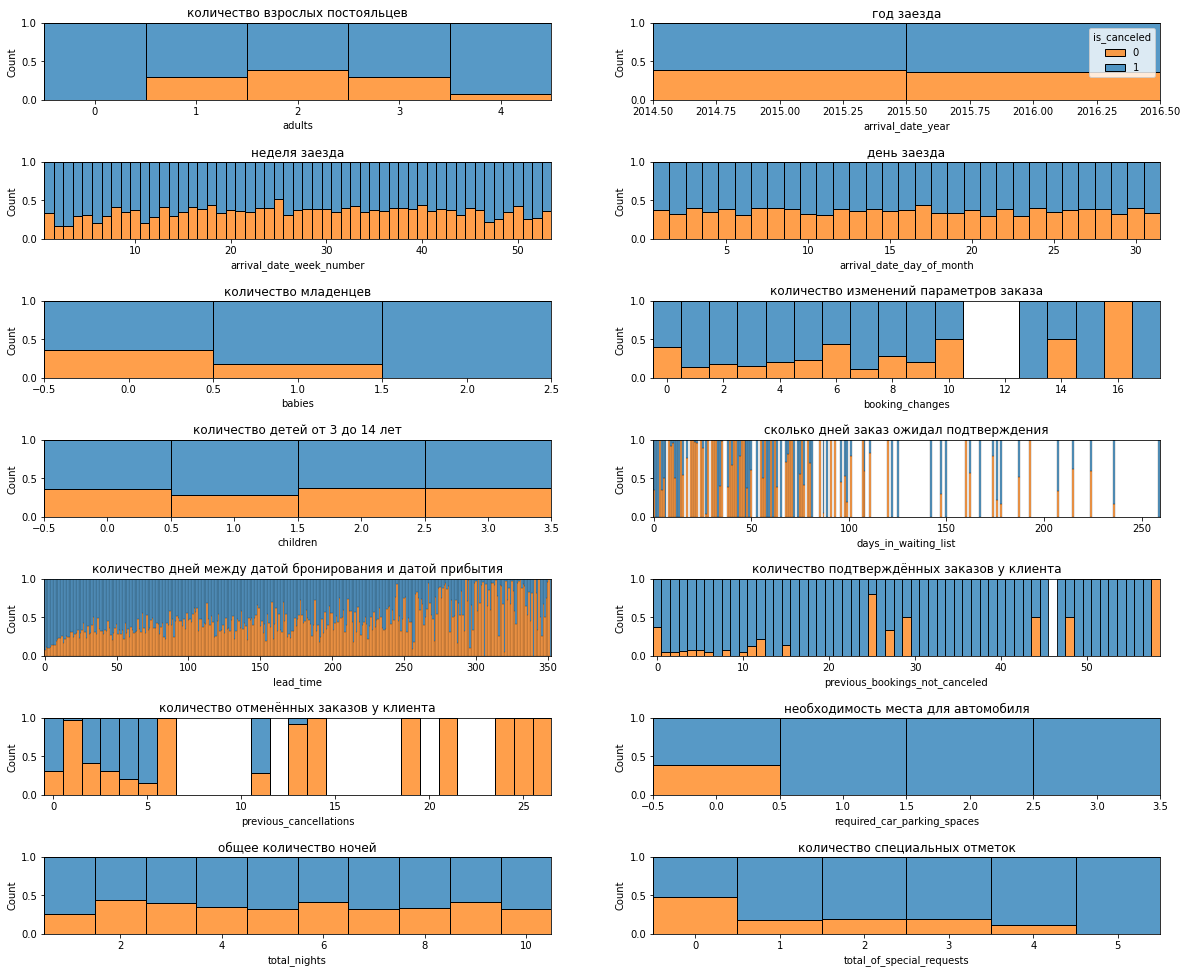

In [32]:
plt.figure(figsize=(20,50))

# Расстояние между графиками
plt.subplots_adjust(hspace = 0.8)

i = 1
for feature_name, title in zip(numerals_column_names_list, numerals_column_titles_list):
    plt.subplot(20,2,i)
    # Аргумент multiple='fill' для каждого столбика делают высоту 100%
    sns.histplot(data=train, x=feature_name, hue='is_canceled', multiple="fill", stat="count", discrete=True, legend=False)\
        .set_title(title)
    
    if i == 2: plt.legend([0, 1], title='is_canceled')
    i += 1

plt.show()

#### Диаграммы размаха по численным признакам

<Figure size 1440x14400 with 0 Axes>

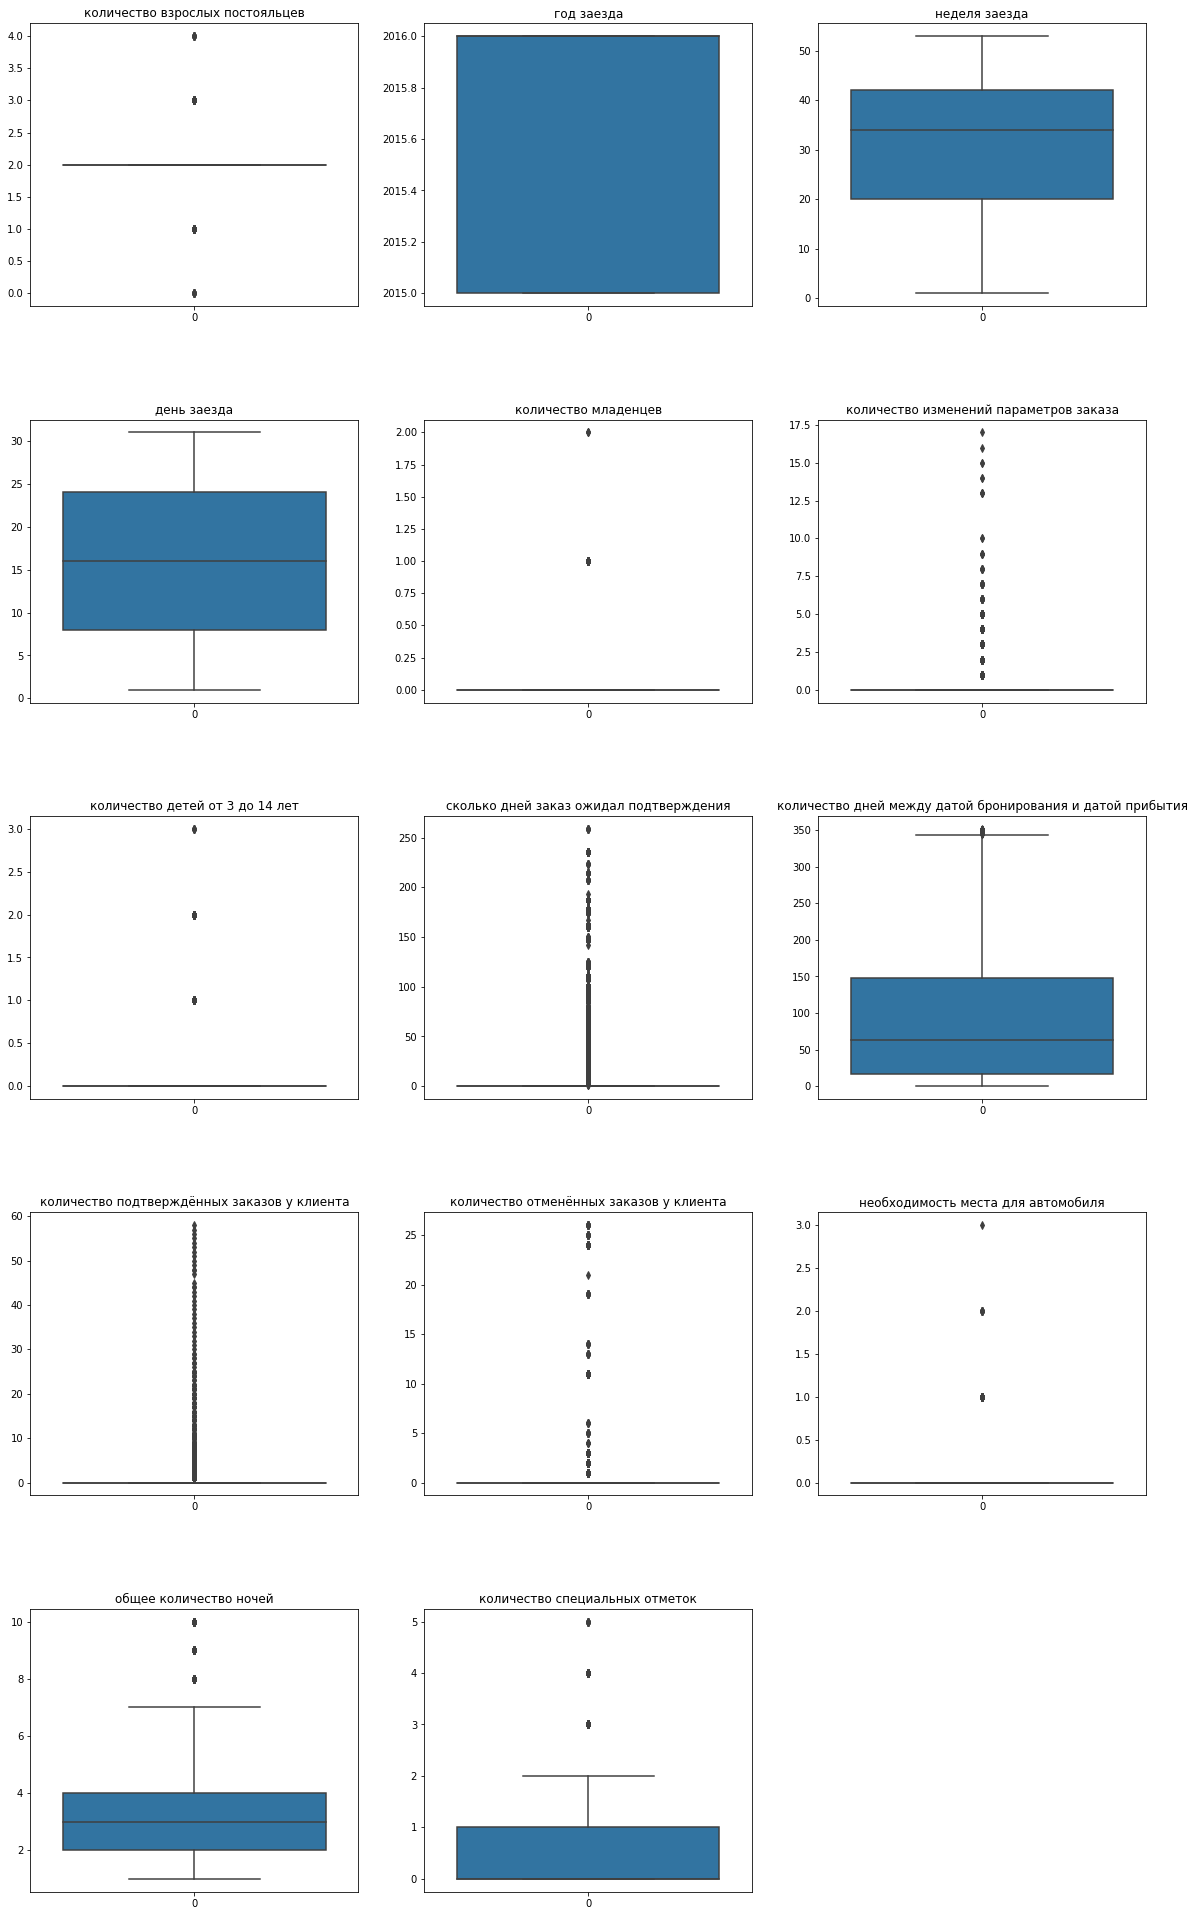

In [33]:
plt.figure(figsize=(20,200))

# Размер каждого графика (относительный), есть разница до или после `plt.subplots_adjust`
plt.subplots(figsize=(20,100));

# Расстояние между графиками
plt.subplots_adjust(hspace = 0.4)

i = 1
for feature_name, title in zip(numerals_column_names_list, numerals_column_titles_list):
    plt.subplot(14,3,i)
    # Аргумент multiple='fill' для каждого столбика делают высоту 100%
    sns.boxplot(data=train[feature_name]).set_title(title)
    
    i += 1

plt.show()

In [34]:
train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000,64583.00000,64583.000000,64583.000000,64583.000000,64583.000000,64583.000000
mean,43498.804113,0.365328,94.311119,2015.720948,31.284316,15.860025,1.840314,0.070870,0.006952,0.027329,0.125559,0.10862,0.193472,3.367775,0.057012,0.515321,3.052878
std,25664.974744,0.481526,93.676618,0.448536,13.484529,8.762187,0.473610,0.321868,0.083648,0.163042,0.968256,1.33264,0.592391,18.327538,0.232800,0.753329,1.740302
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19022.500000,0.000000,17.000000,2015.000000,20.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40477.000000,0.000000,63.000000,2016.000000,34.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67496.500000,1.000000,148.000000,2016.000000,42.000000,24.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,352.000000,2016.000000,53.000000,31.000000,4.000000,3.000000,2.000000,1.000000,26.000000,58.00000,17.000000,259.000000,3.000000,5.000000,10.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


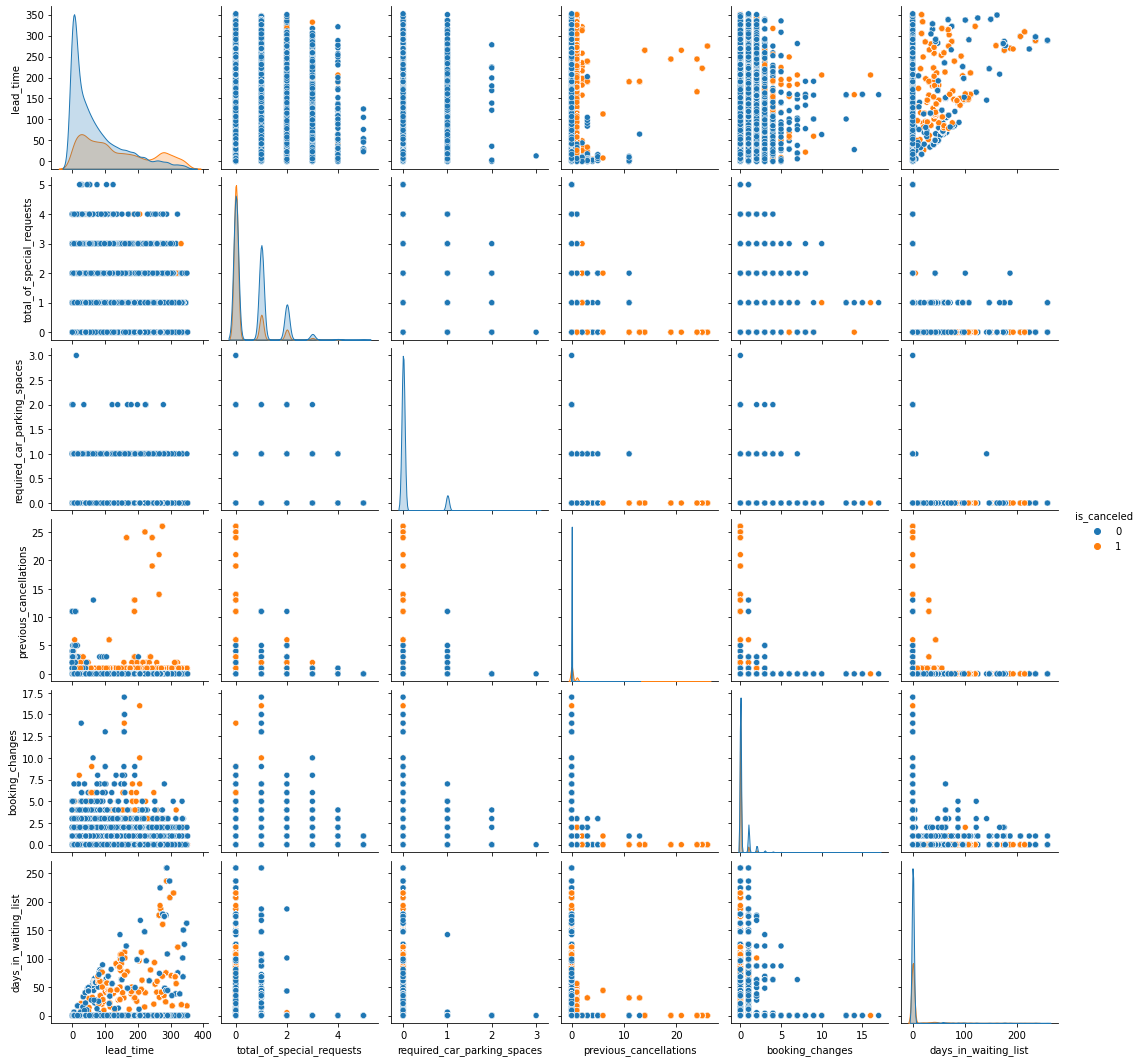

In [35]:
sns.pairplot(
    data=train[['lead_time', 'total_of_special_requests', 'required_car_parking_spaces', 'previous_cancellations',\
                'booking_changes', 'days_in_waiting_list', 'is_canceled']],
    hue='is_canceled'
);

#### Вывод

**Наиболее кореллирующие признаки**

- `lead_time` — количество дней между датой бронирования и датой прибытия
- `total_of_special_requests` — количество специальных отметок
- `required_car_parking_spaces` — необходимость места для автомобиля
- `previous_cancellations` — количество отменённых заказов у клиента
- `booking_changes` — количество изменений параметров заказа
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения

Кол-во дней от брони до прибытия сильно связано с номером записи, скорее всего по тому что они идут по порядку вместе со времением, а данные представлены с 2015-09-21 по 2016-11-14 то есть 420 дней. По этому далее используется только `lead_time`, а `id` не используется.

- Обычно количество постояльцев: 2  
- В 2016 году было больше клиентов чем в 2015  
- Самое большое кол-во клиентов в октябре, сентябре, августе, а меньше всего в марте, феврале, январе  
- Доля клиентов с младенцами 0.7%
- Доля клиентов с детьми 5.4%
- Место для автомобиля нужно для 5.7% клиентов
- В основном на 2, 3, 1, 4 дня
- Кол-во спец отметок: 0 — 62.0%, 1 — 26.1%, 2 — 9.9%

- Больше всего типов заказчика "Transient" 70.0% и они отказываются от брони меньше других, меньше всего типов "Group" 0.44% и самое большоее соотношение отказов
- Лучший канал дистрибуции "TA/TO" 83.4% среди них отказов меньше всего, худший "GDS" 0.15%, среди "Direct" больше всего отказов
- 2.7% гостей делают бронь второй раз, среди них отказов от брони больше
- В основном выбирают опцию заказа "BB" 79.2%, а меньше всего "FB" 0.70% среди них менше всего отказов, больше всего отказов среди "BB" и "SC"
- Тип забронированной комнате выбирается с таким приоритетом: A (77.2%), D (14.4%), F (1.87%), B (1.3%), G (0.91%), C (0.35%), больше всего отказов среди "C", меньше в всего среди "A"
- Страна из которой больше всего клиентов: PRT (Португалия) среди них отказов меньше всего

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

#### Функция расчёта прибыли

In [37]:
def calc_profit(room_type, month, total_nights, is_canceled, predict_is_canceled):
    """
    Расчёт прибыли

    room_type — тип забронированной комнаты
    month — полное английское название месяца
    total_nights — общее количество ночей
    is_canceled — бронь отменена фактически
    predict_is_canceled — предсказание отмены брони модели
    """
    
    # ❗ разовое обслуживание значит — разовая уборка
    # ❗ за ночь значит — за сутки
    # ❗ надолго значит — не один день
    # ❗ убытки в случае отмены брони считать один день — (стоимость одной уборки + одной ночи) * сезонный коэффициент
    # ❗ сезонные коэффициенты применяются только к стоимости номера
    
    # Размер депозита
    DEPOSIT_FRACTION = 0.80
    
    # Базовая стоимость номеров отеля: за ночь, за разовое обслуживание
    COSTS = {
        'A': { 'night': 1000, 'one_service': 400 },
        'B': { 'night': 800, 'one_service': 350 },
        'C': { 'night': 600, 'one_service': 350 },
        'D': { 'night': 550, 'one_service': 150 },
        'E': { 'night': 500, 'one_service': 150 },
        'F': { 'night': 450, 'one_service': 150 },
        'G': { 'night': 350, 'one_service': 150 },
    }
    
    night_cost = COSTS[room_type]['night']
    one_service_cost = COSTS[room_type]['one_service']
    
    # Сезонные коэффициенты
    ## весной и осенью 20%
    SPRING_AUTUMN_COEFFICIENT = 1.20
    ## летом 40%
    SUMMER_COEFFICIENT = 1.40
    
    # Преобразование названия месяца в номер месяца
    month_number = datetime.strptime(month, '%B').month
    
    # Проверка является ли этот месяц сезонным
    is_spring_autumn = month_number in [3, 4, 5, 9, 10, 11]
    is_summer = month_number in [6, 7, 8]
    
    # Сезонный коэффициент
    season_coefficent = (SPRING_AUTUMN_COEFFICIENT if is_spring_autumn else 1) * (SUMMER_COEFFICIENT if is_summer else 1)
    
    прибыль = 0
    
    if is_canceled and not predict_is_canceled:
        # Бронь отменена фактически И модель НЕ предсказала это
        # Не получили деньги за то что клиент отменил бронь
        # прибыль отрицательная — убыток за одну уборку без сезонного коэффициента и отдельно с сезонным коэффициентом за ночь
        прибыль = -(one_service_cost + night_cost * season_coefficent)
    
    if is_canceled and predict_is_canceled:
        # Бронь отменена фактически И модель предсказала это, значит депозит заплачен
        # Получили деньги за то что клиент отменил бронь — это покрывает 80% от затрат
        # Но всё равно 20% убытков остаётся
        # прибыль отрицательная — 20% от, убытока за одну уборку без сезонного коэффициента и отдельно с сезонным коэффициентом за ночь
        прибыль = -((one_service_cost + night_cost * season_coefficent) * (1-DEPOSIT_FRACTION))
    
    if not is_canceled:
        # Бронь НЕ отменена — штатно расчитываем прибыль, ничего не теряем, предсказание неважно
        # Сначала получили 80% стоимости от депозита, затем 20% по приезду клиента, то есть полную стоимость 100%
        # За количество ночей за каждые сутки с сезонным коэффициентом и
        # За уборку перед заселением и каждый второй день (за 1, 3, 5, 7, 9, ...) без сезонного коэффициента
        прибыль = night_cost * total_nights * season_coefficent +\
                  one_service_cost * (total_nights // 2 + 1 if total_nights not in [1, 2] else 1)
    
    return прибыль

# Пример
calc_profit('A', 'March', 3, False, True)

4400.0

In [39]:
profit_base = test.apply(
    lambda row: calc_profit(row['reserved_room_type'], row['arrival_date_month'], row['total_nights'],
                            row['is_canceled'], not row['is_canceled']
    ), axis=1
).sum()

profit_base

60586870.0

In [40]:
# С ошибочной функцей было 96 903 090
profit_max = test.apply(
    lambda row: calc_profit(row['reserved_room_type'], row['arrival_date_month'], row['total_nights'],
                            row['is_canceled'], row['is_canceled']
    ), axis=1
).sum()

profit_max

75020118.0

### Шаг 4. Разработка модели ML

#### Обоснование выбора метрики

Выбранная метрика — количество ложноотрицательных ответов, чем их меньше тем лучше.

Плохо если клиент отменил бронь и мы это не предсказали, то есть предсказали что не отменит, то есть 0 — отрицательный и в данном случае ложный. Значит нужно минимизировать количество "не отмен" когда по факту "отмена есть", а случай "отмены" когда по факту "не отмена" не интересует. Ошибка второго рода (False Negative, FN).  

#### Своя метрика

In [42]:
def false_negative_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    false_negative = cm[1, 0]
    return false_negative

In [43]:
# Свой scorer
opposite_false_negative_scorer = make_scorer(recall_score, greater_is_better=False)

#### Подготовка признаков

In [49]:
features_train = train.drop(['id', 'is_canceled'], axis=1)
target_train = train['is_canceled']

features_test = test.drop(['id', 'is_canceled'], axis=1)
target_test = test['is_canceled']

#### Дисбаланс классов

Соотношение класса 0 от общей выборки: 63.47%
Соотношение класса 1 от общей выборки: 36.53%


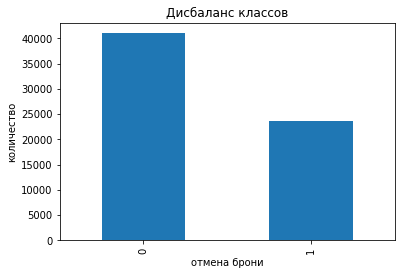

In [50]:
class_imbalance = target_train.value_counts()

class_imbalance.plot(
    title='Дисбаланс классов',
    xlabel='отмена брони', ylabel='количество',
    kind='bar'
);

class_ratio = class_imbalance[0] / len(target_train)
print(f'Соотношение класса 0 от общей выборки: {class_ratio:.2%}')
print(f'Соотношение класса 1 от общей выборки: {1-class_ratio:.2%}')

#### Порядковое кодирование

In [55]:
encoder = OrdinalEncoder()

features_train_oe = pd.DataFrame(encoder.fit_transform(features_train), columns=features_train.columns)
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test), columns=features_test.columns)

#### Обучение дерева решений

In [58]:
grid_params_dt = {
    'max_depth': [1, 6, 11, 20, 21, 28, 32, 50, 62],
    'max_leaf_nodes': [2, 12, 92, 94, 102, 103, 490, 504, 540, 547, 550],
}

In [60]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

clf_dt = GridSearchCV(model_dt, grid_params_dt, scoring=opposite_false_negative_scorer, cv=5)

In [61]:
n_iterations = 1

for value in grid_params_dt.values():
    n_iterations *= len(value)

print('Кол-во сочетаний гиперпараметров:', n_iterations)

Кол-во сочетаний гиперпараметров: 99


In [62]:
%%time

clf_dt.fit(features_train_oe, target_train);

CPU times: user 59.5 s, sys: 166 ms, total: 59.7 s
Wall time: 59.7 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=RandomState(MT19937) at 0x7F97AF761B40),
             param_grid={'max_depth': [1, 6, 11, 20, 21, 28, 32, 50, 62],
                         'max_leaf_nodes': [2, 12, 92, 94, 102, 103, 490, 504,
                                            540, 547, 550]},
             scoring=make_scorer(recall_score, greater_is_better=False))

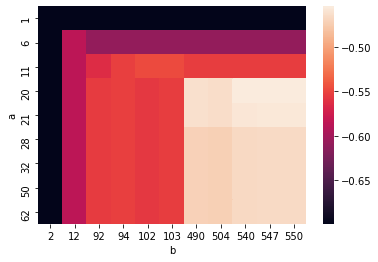

In [63]:
clf_dt_results = pd.DataFrame(clf_dt.cv_results_)
d = pd.DataFrame([*clf_dt_results[['params', 'mean_test_score']].apply(
    lambda x: [x['params']['max_depth'], x['params']['max_leaf_nodes'], x['mean_test_score']], axis=1
)], columns=['a','b','c'])
sns.heatmap(d.pivot("a", "b", "c"));

In [64]:
clf_dt.best_score_

-0.45371369930312466

In [65]:
best_model_dt = clf_dt.best_estimator_
best_model_dt

DecisionTreeClassifier(class_weight='balanced', max_depth=20,
                       max_leaf_nodes=550,
                       random_state=RandomState(MT19937) at 0x7F97A41A2540)

In [66]:
best_model_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': 550,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': RandomState(MT19937) at 0x7F97A41A2540,
 'splitter': 'best'}

#### Обучение случайного леса

In [72]:
grid_params_rf = {
    'n_estimators': range(1, 5),
    'max_depth': [1, 6, 11, 20, 21, 28, 32, 50, 62],
    'max_leaf_nodes': [2, 12, 92, 94, 102, 103, 490, 504, 540, 547, 550],
}

In [73]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [75]:
# Перебор гиперпараметров с использованием кросс-валидации
clf_rf = GridSearchCV(model_rf, grid_params_rf, scoring=opposite_false_negative_scorer, cv=5)

In [76]:
%%time

clf_rf.fit(features_train_oe, target_train)

CPU times: user 2min 25s, sys: 525 ms, total: 2min 25s
Wall time: 2min 26s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=RandomState(MT19937) at 0x7F97AF761B40),
             param_grid={'max_depth': [1, 6, 11, 20, 21, 28, 32, 50, 62],
                         'max_leaf_nodes': [2, 12, 92, 94, 102, 103, 490, 504,
                                            540, 547, 550],
                         'n_estimators': range(1, 5)},
             scoring=make_scorer(recall_score, greater_is_better=False))

In [78]:
best_model_rf = clf_rf.best_estimator_
best_model_rf

RandomForestClassifier(class_weight='balanced', max_depth=32,
                       max_leaf_nodes=550, n_estimators=1,
                       random_state=RandomState(MT19937) at 0x7F97AEDA7140)

In [79]:
clf_rf.best_score_

-0.4695662578586776

#### Оценка прибыли за год в результате работы лучшей модели

In [85]:
test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164.0,2017,August,35,31,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,6
32408,97900,0,21.0,2017,August,35,30,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,2,7
32409,97901,0,23.0,2017,August,35,30,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7
32410,97902,0,34.0,2017,August,35,31,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,4,7


#### Дерево решений на тестовой выборке

In [86]:
predictions_test_dt = best_model_dt.predict(features_test_oe)

#### Случайный лес на тестовой выборке

In [91]:
predictions_test_rf = best_model_rf.predict(features_test_oe)

Accuracy предсказаний — процент совпавших предсказаний

In [92]:
accuracy_score(predictions_test_rf, target_test)

0.6756448229050969

In [93]:
accuracy_score(predictions_test_dt, target_test)

0.6174256448229051

#### Расчёт прибыли

In [98]:
test['predict_dt'] = predictions_test_dt
test['predict_rf'] = predictions_test_rf

In [99]:
profit_dt = test.apply(
    lambda row: calc_profit(row['reserved_room_type'], row['arrival_date_month'], row['total_nights'],
                            row['is_canceled'], row['predict_dt']
    ), axis=1
)

In [100]:
profit_rf = test.apply(
    lambda row: calc_profit(row['reserved_room_type'], row['arrival_date_month'], row['total_nights'],
                            row['is_canceled'], row['predict_rf']
    ), axis=1
)

Вероятность ошибки первого рода (фактически случилось но модель не предсказала)

In [101]:
predict_dt_errorors = 0

for x, y in zip(list(test['is_canceled']), list(predictions_test_dt)):
    if x and not y:
        predict_dt_errorors += 1
        
proba_dt_err = predict_dt_errorors/len(predictions_test_dt)

print(len(predictions_test_dt), predict_dt_errorors, 'Вероятность ошибки первого рода:', proba_dt_err)

32412 11585 Вероятность ошибки первого рода: 0.35742934715537455


In [102]:
predict_rf_errorors = 0

for x, y in zip(list(test['is_canceled']), list(predictions_test_rf)):
    if x and not y:
        predict_rf_errorors += 1
        
proba_rf_err = predict_rf_errorors/len(predictions_test_rf)

print(len(predictions_test_rf), predict_rf_errorors, 'Вероятность ошибки первого рода:', proba_rf_err)

32412 9042 Вероятность ошибки первого рода: 0.2789707515734913


Максимальная прибыль при идеальных предсказаниях, прибыль без внедрения модели и разница между ними

In [103]:
print(profit_max.sum(), '-', profit_base.sum(), '=', profit_max.sum() - profit_base.sum())

75020118.0 - 60586870.0 = 14433248.0


Разработав идеальную модель, она принесёт $14\ 433\ 248$ рублей прибыли — максимально возможная прибыль

In [104]:
print(profit_dt.sum(), 'это на', profit_dt.sum() - profit_base.sum(), 'рублей было бы больше после внедрения депозитов')

61770166.0 это на 1183296.0 рублей было бы больше после внедрения депозитов


Данная модель дерева решений принесёт $1\ 183\ 296$ рублей прибыли

In [105]:
print(profit_rf.sum(), 'это на', profit_rf.sum() - profit_base.sum(), 'рублей было бы больше после внедрения депозитов')

65018886.0 это на 4432016.0 рублей было бы больше после внедрения депозитов


Данная модель случайного леса принесёт $4\ 432\ 016$ рублей прибыли

Если тестовым периодом считать диапазон дат в тестовой выборке, то

In [106]:
dates2 = test.apply(
    lambda x: datetime.strptime(f"{x['arrival_date_year']} {x['arrival_date_month']} {x['arrival_date_day_of_month']}", "%Y %B %d"),
    axis=1
)

In [107]:
range_2 = dates2.describe()

/tmp/ipykernel_121/255266309.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  range_2 = dates2.describe()


In [108]:
range_2['first'], range_2['last'], range_2['first'] - range_2['last']

(Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timedelta('-242 days +00:00:00'))

за 242 дня и за весь этот период модель должна принести от 400 000 рублей

### Шаг 5. Опишите портрет «ненадёжного» клиента

Типичный портрет ненадёжных клиентов, в порядке значимости признаков:

- Много дней между датой бронирования и датой прибытия (lead_time)
- Мало специальных отметок (total_of_special_requests)
- Нет необходимости в месте для автомобиля (required_car_parking_spaces)
- Много отменённых заказов у клиента (previous_cancellations)
- Мало изменений параметров заказа (booking_changes)
- Много дней заказ ожидал подтверждения (days_in_waiting_list)

### Шаг 6. Напишите общий вывод

- Было удалено небольшое количество выбросов из данных.
- Описан портрет "ненадёжного клиента" по самым значимым признакам.
- Лучшая полученная модель — случайный лес принесёт $4\ 432\ 016$ рублей прибыли.
- Доход от внедрения покрывает затраты в $400\ 000$ рублей на разработку модели и больше на $4\ 032\ 016$ рублей.
- Следовательо отвергаем нулевую гипотезу — нужно внедрять систему депозитов с использованием модели.


- Обычно количество постояльцев: 2  
- В 2016 году было больше клиентов чем в 2015  
- Самое большое кол-во клиентов в октябре, сентябре, августе, а меньше всего в марте, феврале, январе  
- Доля клиентов с младенцами 0.7%
- Доля клиентов с детьми 5.4%
- Место для автомобиля нужно для 5.7% клиентов
- В основном на 2, 3, 1, 4 дня
- Кол-во спец отметок: 0 — 62.0%, 1 — 26.1%, 2 — 9.9%


- Больше всего типов заказчика "Transient" 70.0% и они отказываются от брони меньше других, меньше всего типов "Group" 0.44% и самое большоее соотношение отказов
- Лучший канал дистрибуции "TA/TO" 83.4% среди них отказов меньше всего, худший "GDS" 0.15%, среди "Direct" больше всего отказов
- 2.7% гостей делают бронь второй раз, среди них отказов от брони больше
- В основном выбирают опцию заказа "BB" 79.2%, а меньше всего "FB" 0.70% среди них менше всего отказов, больше всего отказов среди "BB" и "SC"
- Тип забронированной комнате выбирается с таким приоритетом: A (77.2%), D (14.4%), F (1.87%), B (1.3%), G (0.91%), C (0.35%), больше всего отказов среди "C", меньше в всего среди "A"
- Страна из которой больше всего клиентов: PRT (Португалия) среди них отказов меньше всего